In [6]:
from tensorflow.keras.models import load_model
import cv2, numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

In [7]:
fer_model = load_model("fer_model.h5") # self-trained model based on CNN with 53% accuracy

In [8]:
emotion_labels = ['angry','disgust','fear','happy','neutral','sad','surprise']

In [9]:
def predict_emotion(img_input):
    if isinstance(img_input, str):  
        img = cv2.imread(img_input, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (48,48))
        img = img.reshape(1,48,48,1) / 255.0
    else:  
        img = img_input
    prediction = fer_model.predict(img)
    return emotion_labels[np.argmax(prediction)]

In [10]:
# have to be mapped to only 4 emotions as that is what the Music dataset is provided with

def map_emotion_to_mood(emotion):
    mapping = {
        'happy': 'Happy',
        'neutral': 'Calm',
        'sad': 'Sad',
        'surprise': 'Energetic',
        'angry': 'Calm',
        'fear': 'Calm',
        'disgust': 'Calm'
    }
    return mapping.get(emotion, 'Calm')

In [11]:
data = pd.read_csv("278k_song_labelled.csv") # dataset with 278k songs having various acoustic factors determining the mood
uri_df = pd.read_csv("278k_labelled_uri.csv") # spotify track ID corresponding to the song. useful to recommend song links than their IDs
data['uri'] = uri_df['uri']
data['spotify_link'] = data['uri'].apply(lambda u: f"https://open.spotify.com/track/{u.split(':')[-1]}")
X = data[['danceability','energy','loudness','acousticness','instrumentalness','liveness','valence','tempo']]
y = data['labels']
label_map = {0:'Calm', 1:'Happy', 2:'Sad', 3:'Energetic'}
y = y.map(label_map)

In [12]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X) # scales every element such that all the columns have mean 0 and variance 1

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

,n_neighbors,5
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


In [14]:
def recommend_songs(mood, n):
    subset = data[data['labels'] == list(label_map.keys())[list(label_map.values()).index(mood)]]
    return subset.sample(n=min(n, len(subset)))[['spotify_link']]

In [16]:
import matplotlib.pyplot as plt
import os, random
def get_random_test_image(test_dir="test"):
    class_folder = random.choice(os.listdir(test_dir))
    folder_path = os.path.join(test_dir, class_folder)
    img_name = random.choice(os.listdir(folder_path))
    img_path = os.path.join(folder_path, img_name)
    return img_path, class_folder

In [17]:
def run_model_random_emotion(n=5):
    img_path, true_label = get_random_test_image()
    print(f"\n[Picked Test Image] {img_path} (True Label: {true_label})")

    emotion = predict_emotion(img_path)
    music_mood = map_emotion_to_mood(emotion)

    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    plt.matshow(img, cmap='gray')
    plt.title(f"True: {true_label}\nPredicted Emotion: {emotion}\nMapped Mood: {music_mood}")
    plt.axis('off')
    plt.show()

    print(f"Recommended songs for a {emotion} mood are:")
    songs = recommend_songs(music_mood, n)
    print(songs)


[Picked Test Image] test/surprise/PublicTest_46929671.jpg (True Label: surprise)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


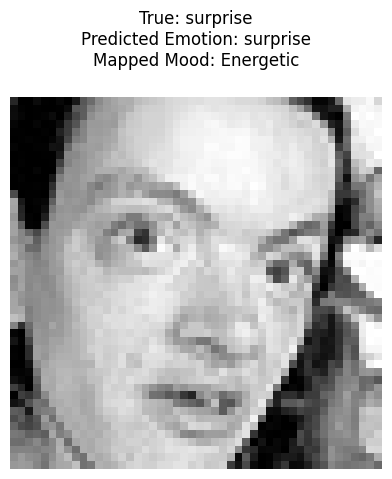

Recommended songs for a surprise mood are:
                                                 spotify_link
37948   https://open.spotify.com/track/1VPKP5oeCAITn8LnbXwqxi
246236  https://open.spotify.com/track/3hKw8fseIefsWDpaINxGn8
238780  https://open.spotify.com/track/6Zgh4LctcDYFk52Qgi8X95


In [30]:
pd.set_option('display.max_colwidth', None) # to prevent truncation of spotify links, preventing broken links
total_songs = int(input("Number of songs:"))
run_model_random_emotion(total_songs)


[KNN] Test Accuracy: 84.11%

Classification Report:
               precision    recall  f1-score   support

        Calm       0.85      0.81      0.83     16472
   Energetic       0.92      0.95      0.93      8424
       Happy       0.81      0.86      0.84     21304
         Sad       0.81      0.75      0.78      9388

    accuracy                           0.84     55588
   macro avg       0.85      0.84      0.85     55588
weighted avg       0.84      0.84      0.84     55588



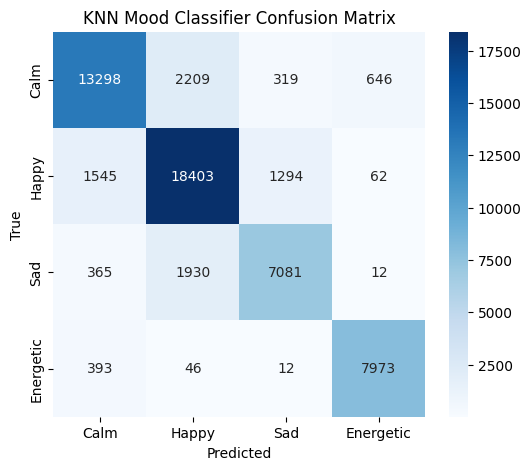

In [20]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Predict on test set
y_pred = knn.predict(X_test)

# Accuracy
acc = accuracy_score(y_test, y_pred)
print(f"\n[KNN] Test Accuracy: {acc*100:.2f}%")

# Classification Report
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred, labels=list(label_map.values()))
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_map.values(),
            yticklabels=label_map.values())
plt.title("KNN Mood Classifier Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Checking real world images

In [21]:
def get_image(img_path=None):
    """
    Get image path from argument or ask user.
    """
    if img_path is None:
        img_path = input("Enter the path to the image: ").strip()
    return img_path

In [22]:
def preprocess_image(img_path, target_size=(48,48)):
    """
    Reads an image, resizes to target size, normalizes for model.
    (No face detection — handled elsewhere)
    """
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError(f"Could not load image: {img_path}")
    
    img = cv2.resize(img, target_size)
    img = img / 255.0
    img = np.expand_dims(img, axis=-1)  # Add channel
    img = np.expand_dims(img, axis=0)   # Add batch
    return img

In [23]:
def run_model_on_image(img_path, n=5):
    """
    Preprocess image, predict emotion, map to mood, and recommend songs.
    """
    processed_img = preprocess_image(img_path)
    emotion = predict_emotion(processed_img)  # You already handle detection inside
    music_mood = map_emotion_to_mood(emotion)

    # Display original image
    raw_img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    plt.matshow(raw_img, cmap='gray')
    plt.title(f"Predicted Emotion: {emotion}\nMapped Mood: {music_mood}")
    plt.axis('off')
    plt.show()

    # Recommend songs
    print(f"Recommended songs for a {emotion} mood are:")
    songs = recommend_songs(music_mood, n)
    print(songs)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


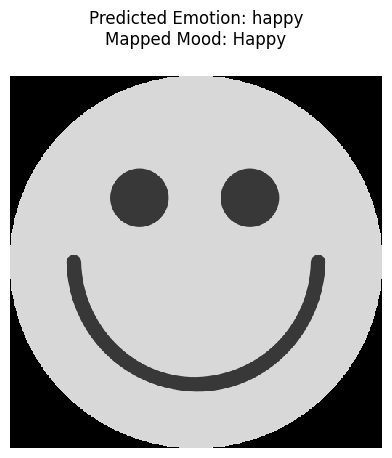

Recommended songs for a happy mood are:
                                                 spotify_link
103899  https://open.spotify.com/track/7ozXoMBdjxtS3U2tbzo9Ay
14807   https://open.spotify.com/track/1YgORSExz0enHd3NvIFZD5
73875   https://open.spotify.com/track/2iQcApXwDKf5KPXTLi6VGl


In [31]:
total_songs = int(input("Number of songs:"))
img_path = get_image()
run_model_on_image(img_path, total_songs)